In [1]:
import os

os.chdir("../../")

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_handling import ingestion

sns.set_theme(context="paper", font_scale=1.15, style="whitegrid")

In [2]:
ncg_consumption, gaspool_consumption, the_consumption = ingestion.read_consumption()
consumption = pd.concat([ncg_consumption + gaspool_consumption, the_consumption]).sort_index()

eua_auctions = ingestion.read_eua_auctions()
eua_auctions = eua_auctions.sort_index().fillna(method="ffill")

d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Text(0, 0.5, 'Natural Gas Consumption [MWh]')

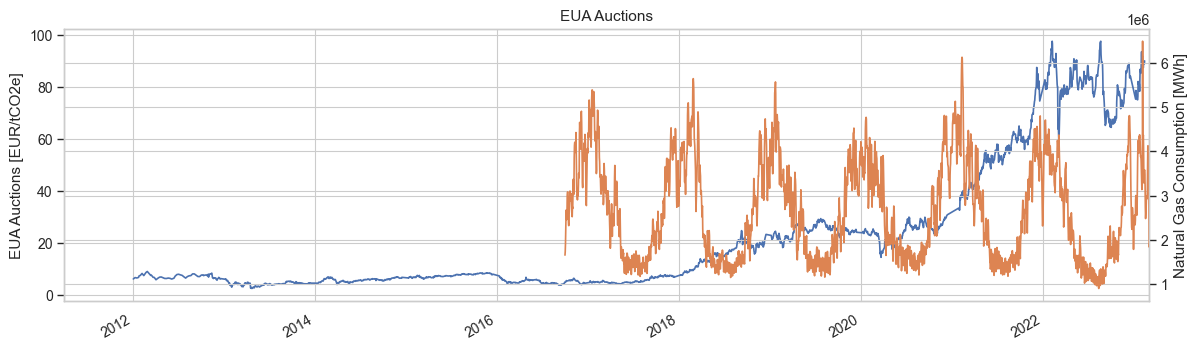

In [3]:
fig, ax = plt.subplots(figsize=(14, 4))
ax2 = ax.twinx()

eua_auctions.plot(ax=ax, title="EUA Auctions")
consumption.plot(ax=ax2, color="C1")

ax.set_ylabel("EUA Auctions [EUR/tCO2e]")
ax2.set_ylabel("Natural Gas Consumption [MWh]")

In [4]:
def model(x, x0, y0, y1, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x: k1 * x + y0, lambda x: k2 * x + y1])

# Read model parameters with Pickle
with open("models/piecewise_linear_temperature_model.pkl", "rb") as f:
    model_parameters = pickle.load(f)

In [5]:
temperatures = ingestion.read_temperatures()
modelled_consumption = pd.Series(model(temperatures.to_numpy(), *model_parameters),  index=temperatures.index)
model_residuals = (consumption - modelled_consumption).dropna()

Text(0.5, 1.0, 'EUA prices and consumption residuals')

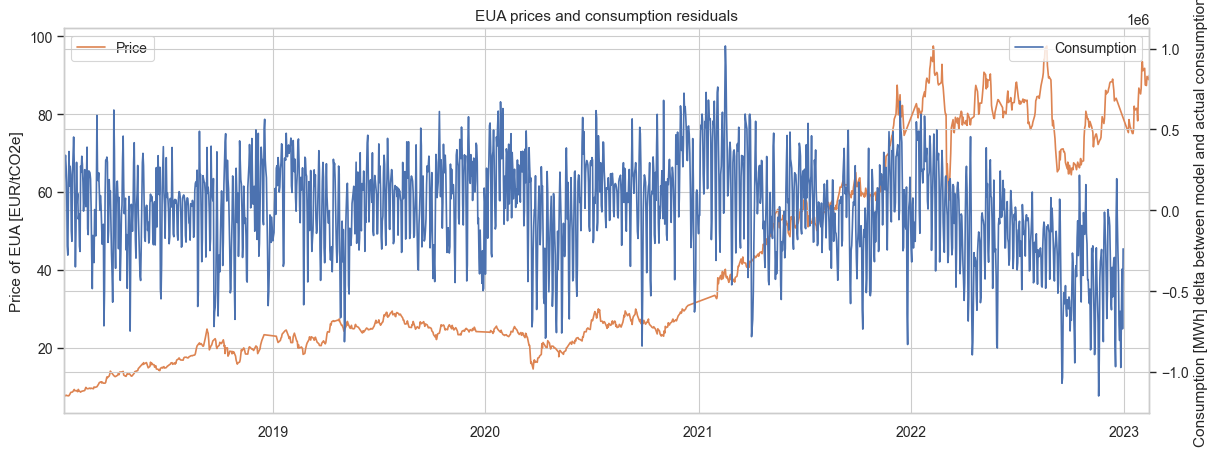

In [6]:
# Plot prices and consumption residuals on the same plot but with different y-axes
fig, ax1 = plt.subplots(figsize=(14, 5))
ax2 = ax1.twinx()

# From 2018 onwards
model_residuals.loc["2018":].plot(ax=ax2, color="C0", label="Consumption")
eua_auctions.loc["2018":].plot(ax=ax1, color="C1", label="Price")

ax1.set_ylabel("Price of EUA [EUR/tCO2e]")
ax2.set_ylabel("Consumption [MWh] delta between model and actual consumption")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

ax1.set_title("EUA prices and consumption residuals")

Text(0.5, 1.0, 'EUA prices and consumption residuals (30d rolling mean)')

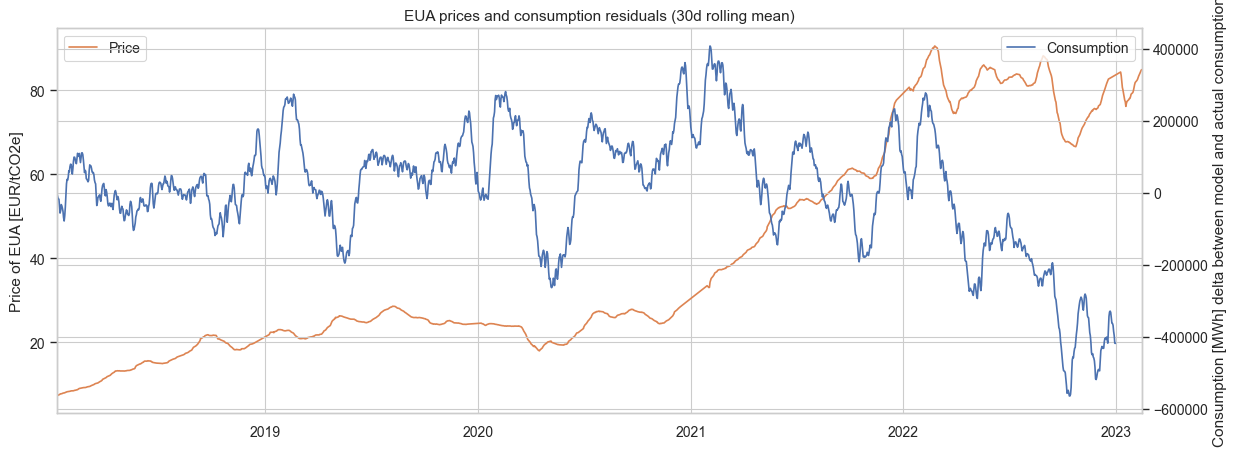

In [7]:
# Plot prices and consumption residuals on the same plot but with different y-axes
fig, ax1 = plt.subplots(figsize=(14, 5))
ax2 = ax1.twinx()

# From 2018 onwards
model_residuals.rolling(window='30d').mean().loc["2018":].plot(ax=ax2, color="C0", label="Consumption")
eua_auctions.rolling(window='30d').mean().loc["2018":].plot(ax=ax1, color="C1", label="Price")

ax1.set_ylabel("Price of EUA [EUR/tCO2e]")
ax2.set_ylabel("Consumption [MWh] delta between model and actual consumption")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

ax1.set_title("EUA prices and consumption residuals (30d rolling mean)")

### Correlation coefficient

In [8]:
# Find intersection of indeces
intersection = model_residuals.index.intersection(eua_auctions.index)

# Calculate correlation
correlation_coefficient = model_residuals.loc[intersection].corr(eua_auctions.loc[intersection])

# Correlation on 30d means
correlation_coefficient_30d = model_residuals.loc[intersection].rolling(window='30d').mean().corr(eua_auctions.loc[intersection].rolling(window='30d').mean())

print(f"Correlation coefficient: {correlation_coefficient:.3f}")
print(f"Correlation coefficient (30d rolling mean): {correlation_coefficient_30d:.3f}")

Correlation coefficient: -0.207
Correlation coefficient (30d rolling mean): -0.278


### Correlation with natural gas price itself

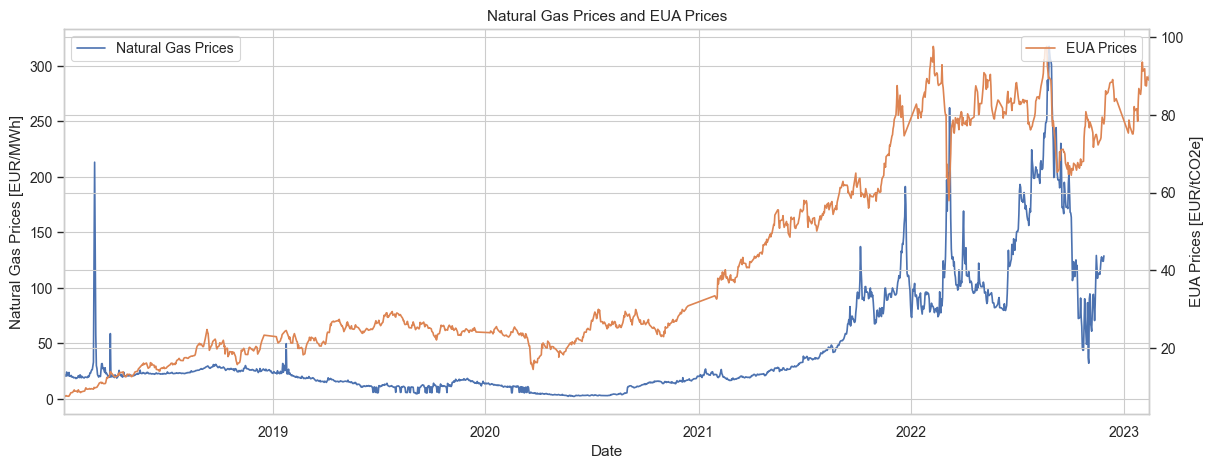

In [12]:
ncg_prices, gaspool_prices, the_prices = ingestion.read_imbalance_prices()
prices = pd.concat([(ncg_prices + gaspool_prices).dropna() / 2, the_prices]).sort_index()

# Plot natural gas prices and EUA prices
fig, ax1 = plt.subplots(figsize=(14, 5))
ax2 = ax1.twinx()

prices.loc["2018":].plot(ax=ax1, color="C0", label="Natural Gas Prices")
eua_auctions.loc["2018":].plot(ax=ax2, color="C1", label="EUA Prices")

ax1.set_ylabel("Natural Gas Prices [EUR/MWh]")
ax2.set_ylabel("EUA Prices [EUR/tCO2e]")
ax1.set_title("Natural Gas Prices and EUA Prices")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

In [14]:
# Correlation between natural gas prices and EUA prices
intersection = prices.index.intersection(eua_auctions.index)
correlation_coefficient = prices.loc[intersection].corr(eua_auctions.loc[intersection])

# Correlation on 30d means
correlation_coefficient_30d = prices.loc[intersection].rolling(window='30d').mean().corr(eua_auctions.loc[intersection].rolling(window='30d').mean())

print(f"Correlation coefficient: {correlation_coefficient:.3f}")
print(f"Correlation coefficient (30d rolling mean): {correlation_coefficient_30d:.3f}")

Correlation coefficient: 0.770
Correlation coefficient (30d rolling mean): 0.794
